In [6]:
import sys
import os
import pandas as pd
from pyprojroot import here

sys.path.insert(0, os.path.join(here()))

from src.utils.eda_utils import WpEDS

import warnings
warnings.filterwarnings('ignore')

## plotting libraries and setting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(24, 12)})
# small_size = 8
# medium_szie = 10
big_size = 18
plt.rc('font', size=big_size)          # controls default text sizes
plt.rc('axes', titlesize=big_size)     # fontsize of the axes title
plt.rc('axes', labelsize=big_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=big_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=big_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=big_size)    # legend fontsize
plt.rc('figure', titlesize=big_size)  # fontsize of the figure title

#### Read data, convert time, sort time-index

In [2]:
df_train = pd.read_parquet(here("data/transformed/train/train.parquet"))
print("train:", df_train.shape)

df_test = pd.read_parquet(here("data/transformed/test/test.parquet"))
print("test:", df_test.shape)

df_wf1 = pd.read_parquet(here("data/transformed/windforecasts/windforecasts_wf1.parquet"))
print("wf1:",df_wf1.shape)

train: (18757, 7)
test: (7488, 1)
wf1: (104832, 5)


#### In this analysis I am slicing a portion of the wind data which is closest to each sample of wind power. This is an approximation, but can give us a good perspective of out data.

Let's create an object with WpEDS class

In [3]:
wp1 = WpEDS(df_train[["wp1"]].rename(columns={"wp1":"wp"}), df_wf1)

First checking the correlation between each sample and the x number of samples before it

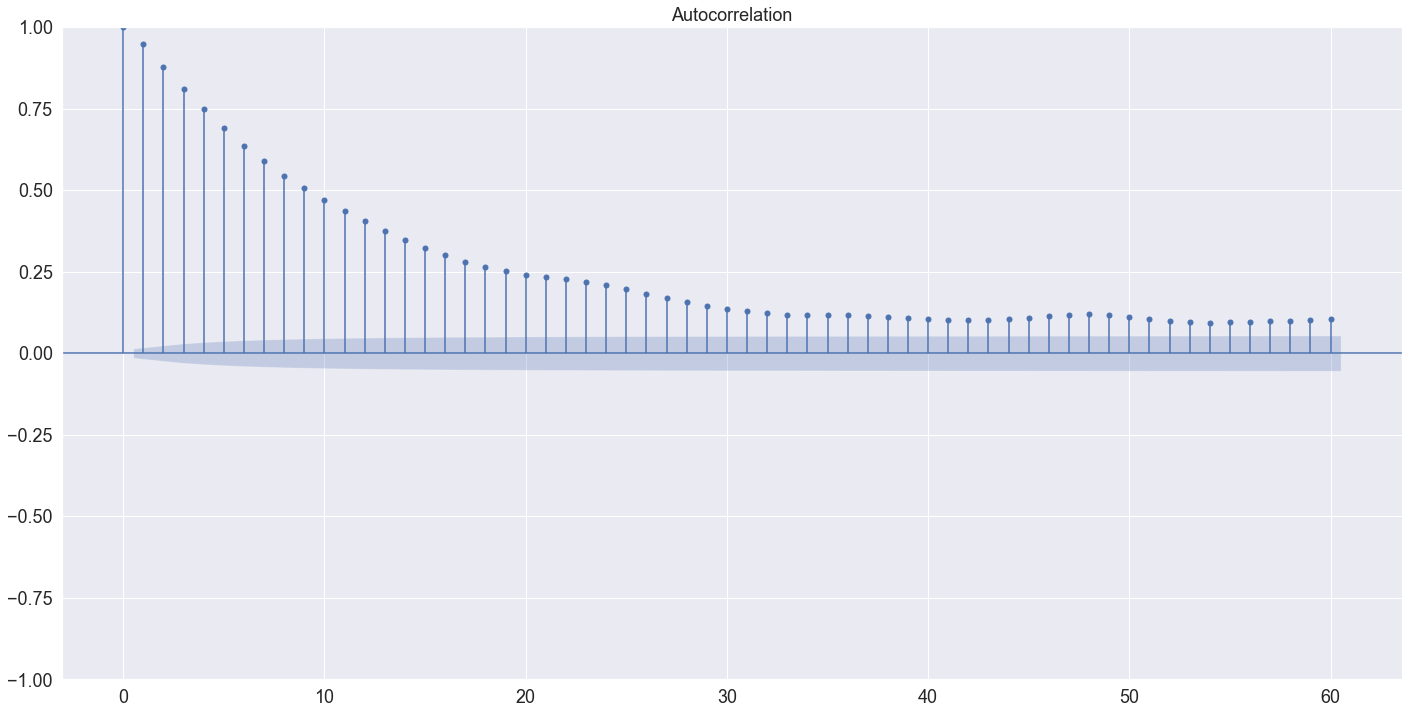

In [7]:
wp1.show_lag_plot(lag=60)

Let's check the missing values of each dataset. We have no missing values in wind power data. There are some missing samples in wind data. We will analyse them later.

In [9]:
wp1.check_missing_values()

wp number of missing values: wp       0
year     0
month    0
day      0
hour     0
dtype: int64
ws number of missing values: hors         0
u        11160
v        11160
ws       11160
wd       11160
year         0
month        0
day          0
dtype: int64


Wind power dataset were provided in a normalized structure. Therefore, we shouldn't see any values below 0 or above 1 for wind power samples. If there is any, we label them as outliers. 

Below, we will check the statistics of each dataset. AS it can be seen, we have no outlier in that manner. WS needs a more detailed and separate analysis. However, a high level analysis of wind speed is also shown below.

In [10]:
wp1.statistics()

                 wp          year         month           day          hour
count  18757.000000  18757.000000  18757.000000  18757.000000  18757.000000
mean       0.252388   2010.159994      6.927174     15.722290     11.496188
std        0.246381      0.895025      3.424789      8.792962      6.922186
min        0.000000   2009.000000      1.000000      1.000000      0.000000
25%        0.050000   2010.000000      4.000000      8.000000      5.000000
50%        0.175000   2010.000000      7.000000     16.000000     11.000000
75%        0.381000   2011.000000     10.000000     23.000000     17.000000
max        0.947000   2012.000000     12.000000     31.000000     23.000000
                hors             u            v            ws            wd  \
count  104832.000000  93672.000000  93672.00000  93672.000000  93672.000000   
mean       24.500000      1.598712     -0.09969      4.072487    144.814262   
std        13.853465      3.052834      2.87600      1.889861     93.518468   


Another way to check for possible outliers, and in general seeing the distribution of our data is by looking at the boxplot. So, let's look at it.

Wind power data looks like a very good data with regard to outliers and distribution.

<AxesSubplot:>

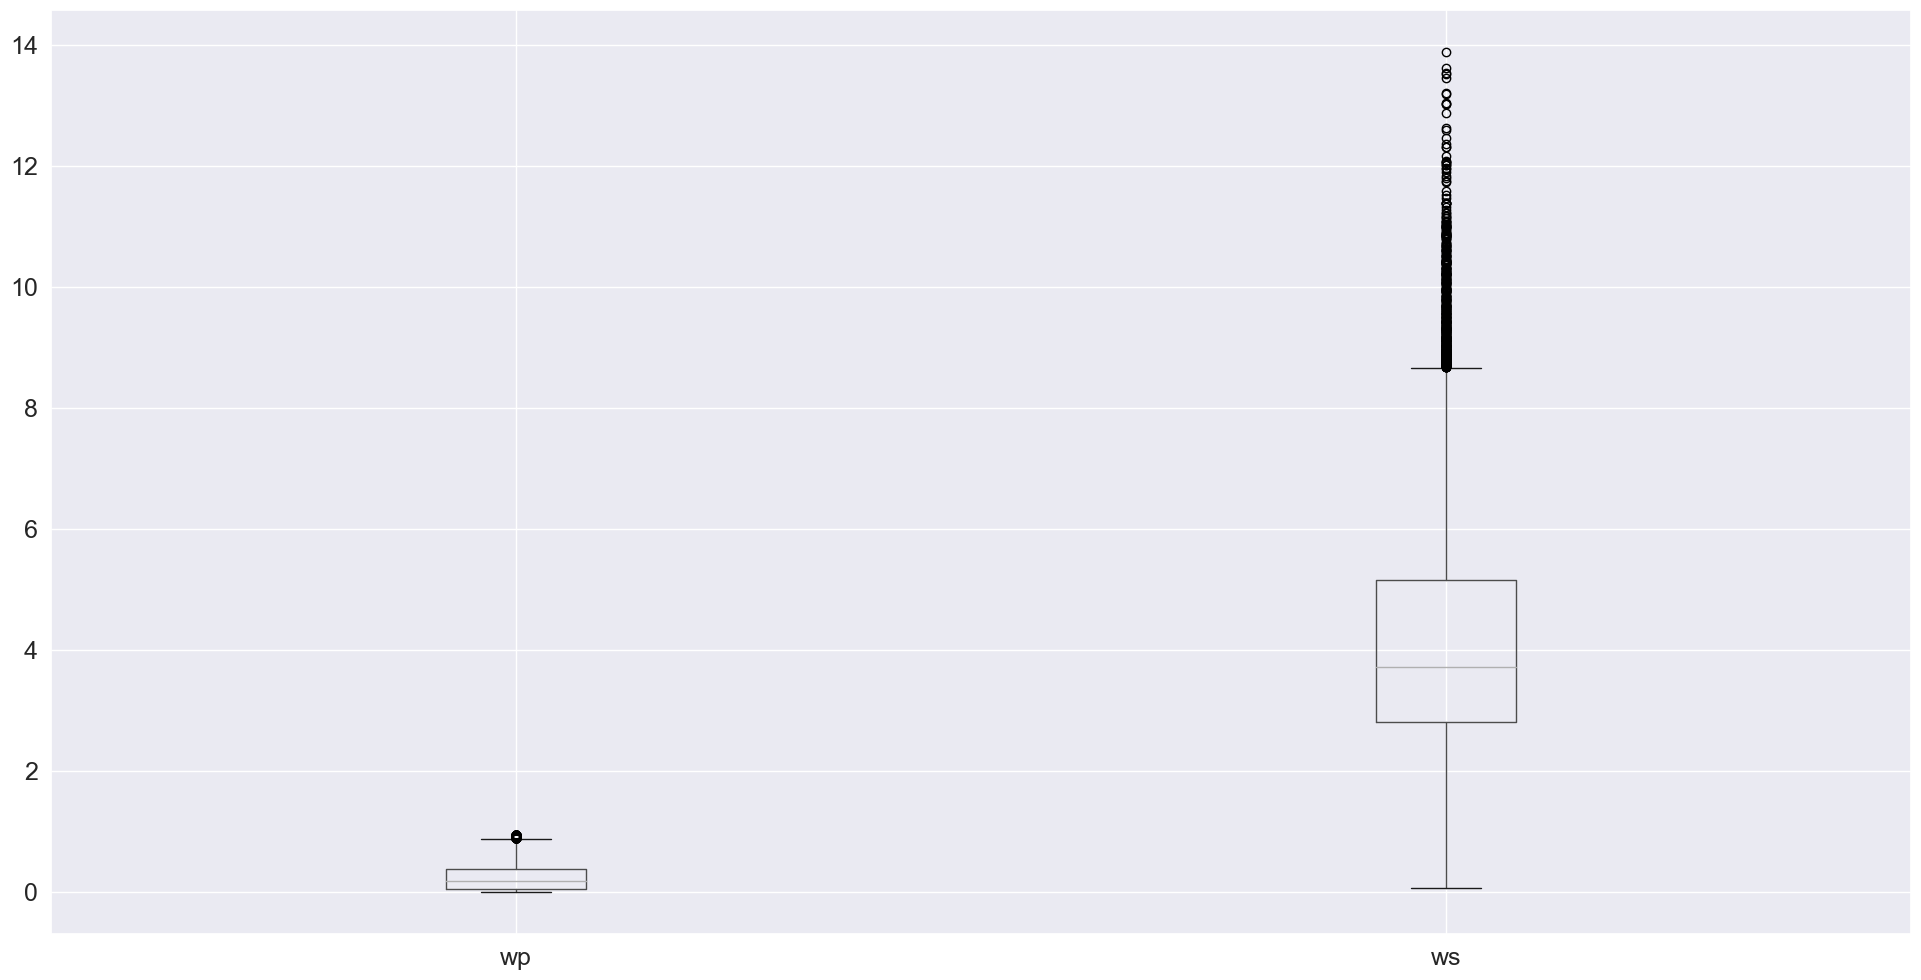

In [7]:
wp1.plot_boxplot()

We also can take a look at violin plot for a better understanding of the dataset

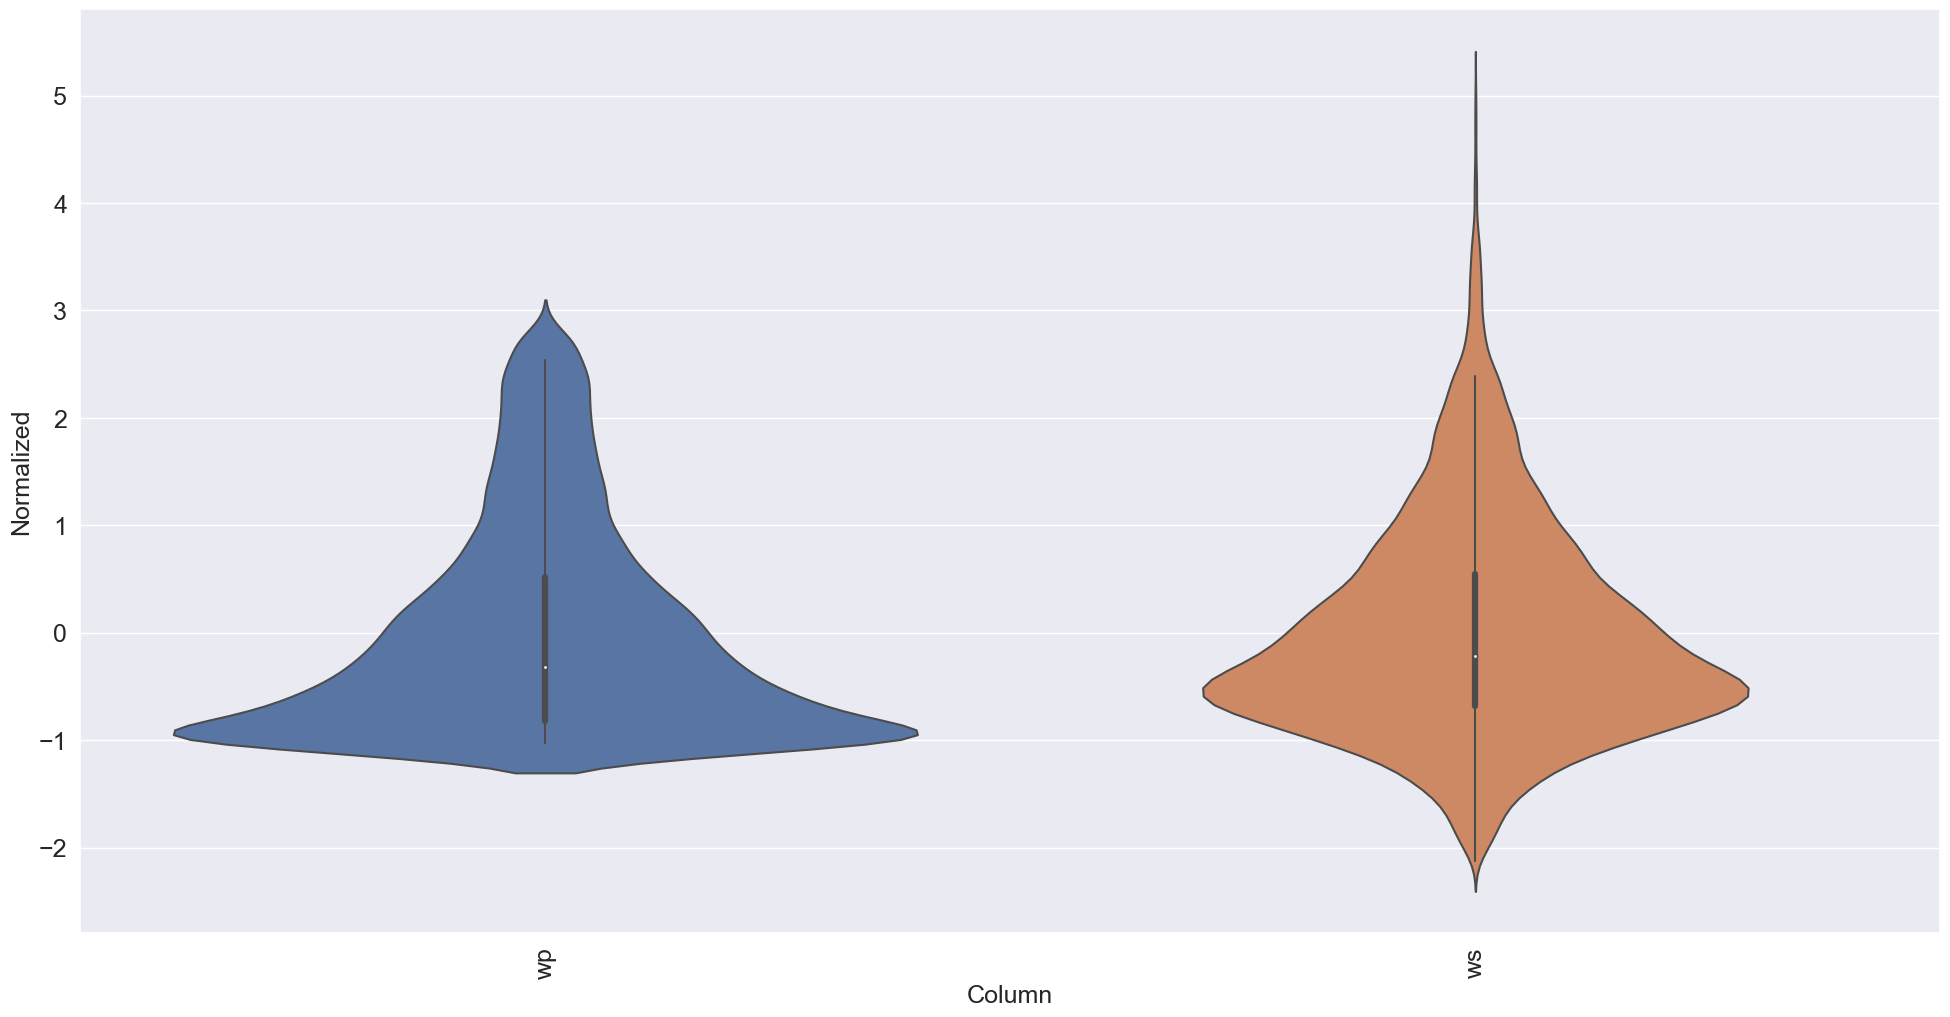

In [8]:
wp1.plot_violinplot()

Checking the available data range

In [11]:
wp1.check_data_range()

WP first valid day: 2009-07-01 00:00:00 | WP last valid day: 2012-06-26 12:00:00
WS first valid day: 2009-07-01 00:00:00 | WS last valid day: 2012-06-26 12:00:00
WP shape: (18757, 5)
WS shape: (104832, 8)


One way to measure peak performance is to use a graph of a power curve. A power curve is a graph that shows the wind speed and the output power of the wind turbine over a range of wind speeds from zero to the maximum wind speed for which the wind turbine is designed.


The output of the generator is shown on the y-axis on the left side, and it indicates power.

Wind power curve usually is a metric that is provided by manufactureres. However, in bigger scale a wind farm should have similar behavior. So, I am plotting the wind power curve to see the relationship between our wind power samples and the selected wind speed samples. 

The figure shows a reasonable distribution of power over different wind speeds.


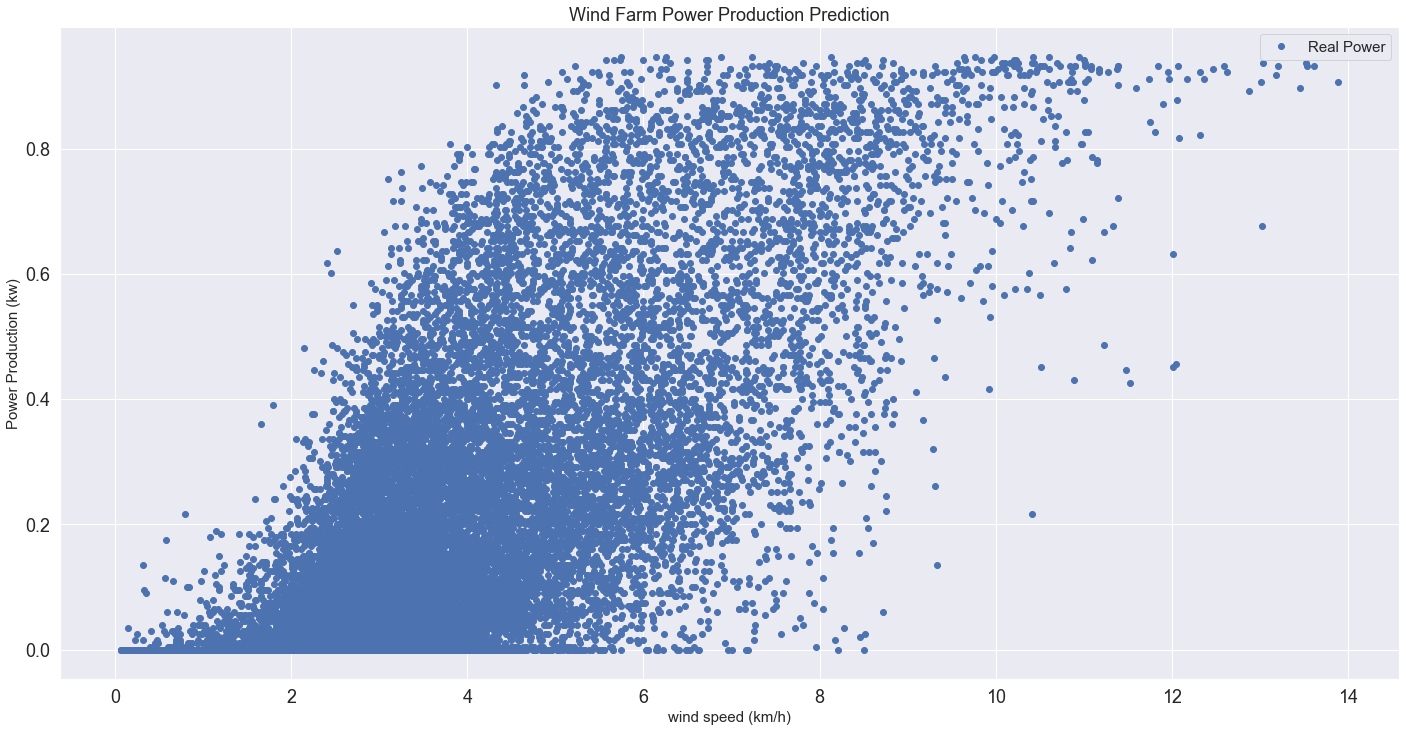

In [14]:
wp1.plot_wind_power_curve()

An important factor is the relationship between wind speed and wind power. So, in order to analyze this relation ship, we can use different metrics. 

Here, first I will check the correlation of wind speed and wind power samples.

70% correlation between the selected samples of wind speed and wind power. This is a good correlation. Usually, a correlation greater than 55% is something that you can count on.

In [9]:
wp1.check_correlation()

,wp,ws
wp,1.00,0.70
ws,0.70,1.00


In the next step let's check another metric for understanding the relation ship between our datasets.

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.


The result shows the value of 0. So, we can reject the null hypothesis.

In [15]:
wp1.grangers_causation_matrix()

,wp_x,ws_x
wp_y,1.0,0.0
ws_y,0.0,1.0


Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.

You can refer to this paper for a detailed explanation of this test:
- https://www.jstor.org/stable/2938278?seq=1#page_scan_tab_contents

In [16]:
wp1.cointegration_test()

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
wp     ::  957.69    > 12.3212   =>   True
ws     ::  123.82    > 4.1296    =>   True


Check for Stationarity and Make the Time Series Stationary. There are two approaches in forecasting time series. Some scientists train their models on a non-stationary data ==> they remove the stationary behavior if it exists in the dataset. Some other use this characteristic in order to analyze their data and provide useful information using it. Anyway, let's check whether our data is stationary or non-stationary.

There is a suite of tests called unit-root tests. The popular ones are:

- Augmented Dickey-Fuller Test (ADF Test)
- KPSS test
- Philip-Perron test

Code reference::
- https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

Here I will use ADF to check if the data is stationary


In our case the analysis shows that our dataset is stationary. In case the data is stationary and you want to remove that characteristic, you can start differencing the data (check pandas diff function) until your data is stationary. Remember to reverse the diffs after your analysis.

In [17]:
for name, column in wp1.data.iteritems():
    WpEDS.adfuller_test(series=column, name=column.name)
    print("\n")

    Augmented Dickey-Fuller Test on "wp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.3273
 No. Lags Chosen       = 33
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ws" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.8855
 No. Lags Chosen       = 45
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




Another way that we can check the detailed behavor of our dataset is by decomposing the timeseries into its three components:
- trend, seasonality and residuals.

Our datasets clearly has a daily seasonality and no meaning ful trend.

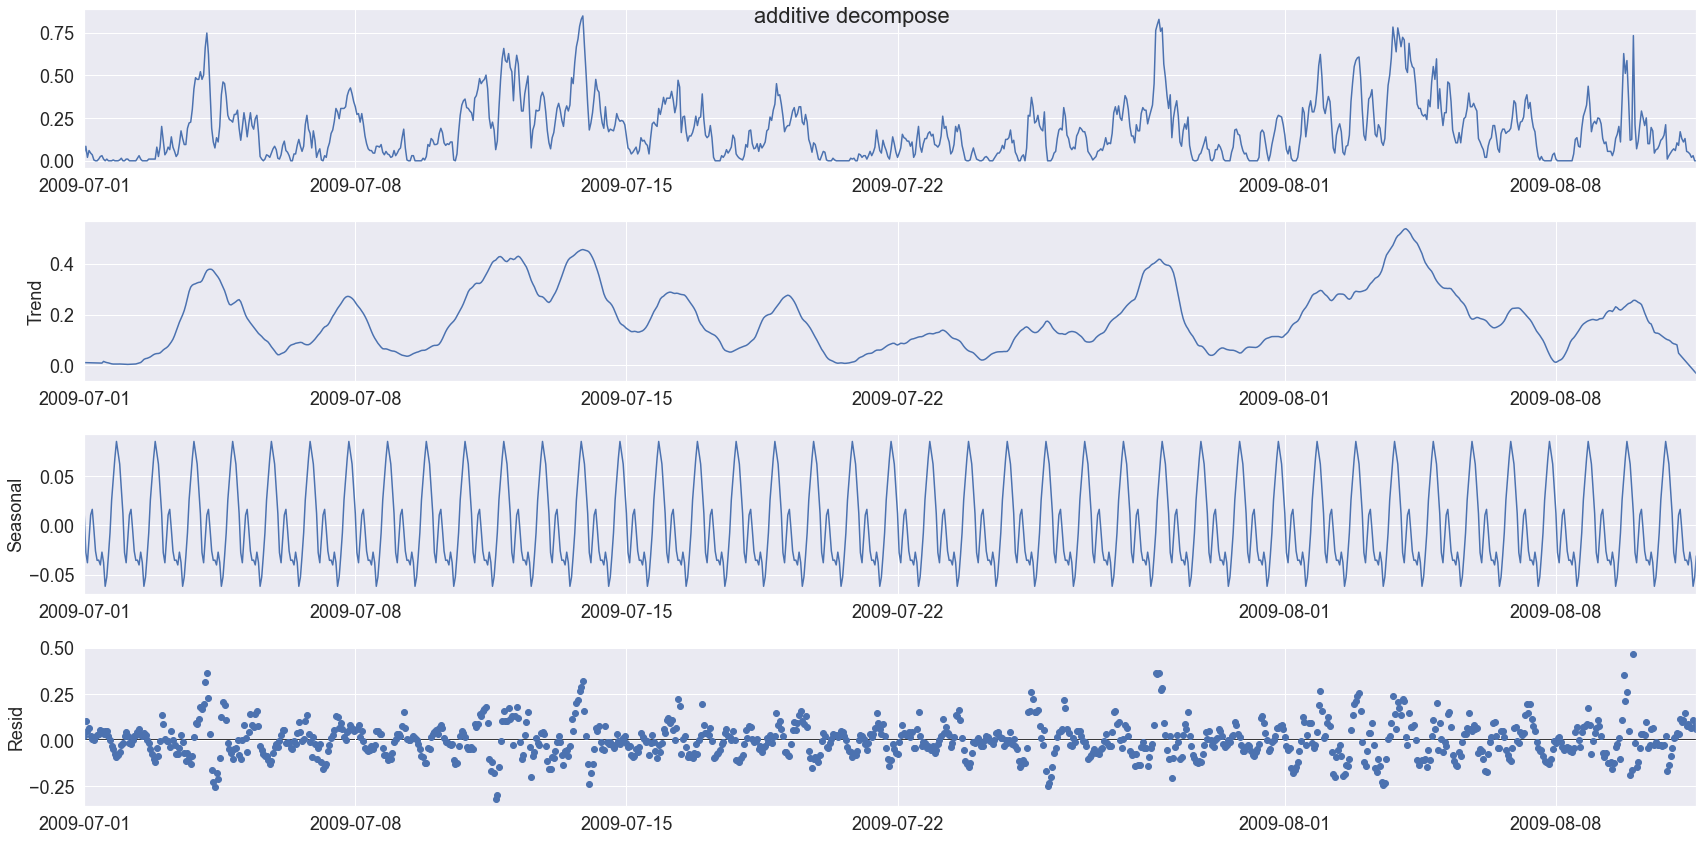

In [18]:
wp1.decopmose_signal(column="wp")